In [ ]:
### CDR
### Generating missingness in CDR column, imputatation and classification of the imputed dataset

In [ ]:
###40% Missingness in CDR

In [ ]:
# Creating a copy of the original dataframe
df_CDR_m40 = df_actual.copy()
df_CDR_m40.head()


,lh.Cerebellum.White.Matter,lh.Cerebellum.Cortex,lh.Thalamus.Proper,lh.Caudate,lh.Putamen,lh.Pallidum,X3rd.Ventricle,X4th.Ventricle,Brain.Stem,lh.Hippocampus,...,adas_Q7SCORE,adas_Q8SCORE,adas_Q9SCORE,adas_Q10SCORE,adas_Q11SCORE,adas_Q12SCORE,adas_Q13SCORE,MOTHDEM,CDR,APOE
0,0.745525,0.794748,0.491765,0.687288,0.354272,0.053029,0.393061,1.000000,0.477280,0.619156,...,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
1,0.592240,0.665080,0.290817,0.503438,0.297870,0.041430,0.545423,0.478379,0.546091,0.398004,...,1.0,0.916667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
2,0.458426,0.530987,0.383385,0.658083,0.419540,0.068931,0.320838,0.414968,0.417480,0.398636,...,1.0,0.916667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
3,0.563800,0.587889,0.369088,0.651455,0.384590,0.048233,0.368835,0.615725,0.418360,0.480851,...,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
4,0.624248,0.664183,0.276727,0.661635,0.520853,0.120530,0.544304,0.180479,0.476558,0.290435,...,1.0,0.750000,1.0,1.0,1.0,1.0,0.8,0,0.0,0


In [ ]:
# Introducing missingness to the 'CDR' column of 40% with the respect to AD_LABEL.

import numpy as np
# Set random seed for reproducibility
seed = 89
np.random.seed(seed)


# Define a function to introduce missingness in 'CDR' based on 'AD_LABEL'
def introduce_missingness(df_CDR_m40):
    # Defining the probability of missingness as 40%
    p_missing = 0.4

    # Generate a boolean mask to identify rows where 'AD_LABEL' has values 2 or 3
    mask = (df_CDR_m40['AD_LABEL'] == 2) | (df_CDR_m40['AD_LABEL'] == 3)

    # Randomly select rows based on the mask and introduce missingness in 'CDR'
    missing_indices = df_CDR_m40[mask].sample(frac=p_missing).index
    df_CDR_m40.loc[missing_indices, 'CDR'] = np.nan

    return df_CDR_m40

  # Call the function to introduce missingness
df_CDR_mis40 = introduce_missingness(df_CDR_m40)


In [ ]:
df_CDR_mis40.tail()

,lh.Cerebellum.White.Matter,lh.Cerebellum.Cortex,lh.Thalamus.Proper,lh.Caudate,lh.Putamen,lh.Pallidum,X3rd.Ventricle,X4th.Ventricle,Brain.Stem,lh.Hippocampus,...,adas_Q7SCORE,adas_Q8SCORE,adas_Q9SCORE,adas_Q10SCORE,adas_Q11SCORE,adas_Q12SCORE,adas_Q13SCORE,MOTHDEM,CDR,APOE
554,0.102050,0.000000,0.000000,0.379090,0.115710,0.014856,0.152403,0.095275,0.018378,0.311250,...,0.2,0.000000,1.00,1.0,1.000000,1.0,0.0,1,NaN,2
555,0.693037,0.668451,0.356448,0.566407,0.445647,0.057959,0.304343,0.132452,0.246746,0.142295,...,1.0,0.416667,1.00,1.0,1.000000,1.0,0.6,0,NaN,0
556,0.600632,0.715813,0.277625,0.483890,0.390352,0.058854,0.482336,0.362199,0.698153,0.252722,...,0.8,0.666667,1.00,1.0,1.000000,1.0,0.6,0,0.5,0
557,0.842654,0.786929,0.188005,0.571366,0.315403,0.042039,0.251464,0.139725,0.234703,0.082283,...,1.0,0.416667,0.75,0.5,0.666667,0.5,0.6,0,0.5,1
558,0.548794,0.615394,0.138131,0.454855,0.208531,0.034581,0.024287,0.199837,0.290168,0.081695,...,1.0,0.666667,1.00,1.0,1.000000,1.0,0.8,1,0.0,0


In [ ]:
# Imputation of 40% missing values in the 'CDR' column using the denoising autoencoder

import tensorflow as tf
import numpy as np

# Replace missing values in the 'CDR' column with a placeholder value (-1)
df_missing_CDR40 = df_CDR_mis40.fillna(-1)  # Replace NaN values with -1

# Defining the layers of the autoencoder
input_dim = len(df_missing_CDR40.columns)  # Input dimension
hidden_dim1 = 126  # Hidden layer dimension for the first hidden layer
hidden_dim2 = 63   # Hidden layer dimension for the second hidden layer

# Define the autoencoder architecture with dropout regularization
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.GaussianNoise(0.1),  # Add Gaussian noise with standard deviation 0.1
    tf.keras.layers.Dense(hidden_dim1, activation='relu'),
    tf.keras.layers.Dropout(0.2),         # Dropout layer after the first hidden layer
    tf.keras.layers.Dense(hidden_dim2, activation='relu'),  # Second hidden layer
    tf.keras.layers.Dropout(0.2),         # Dropout layer after the second hidden layer
    tf.keras.layers.Dense(input_dim, activation='linear')   # Linear activation for continuous output
])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
# Train the autoencoder
autoencoder.fit(df_missing_CDR40, df_missing_CDR40, epochs=50, batch_size=50, validation_split=0.2)

# Using the trained autoencoder to predict and impute missing values
imputed_data = autoencoder.predict(df_missing_CDR40)

# Predicted values are clipped to ensure they fall within the range [0, 1]
# Suitable for the continuous nature of the 'CDR' column.
imputed_data = np.clip(imputed_data, 0, 1)

# Replace missing values in the original dataset with the predicted values
df_imputed_40cdr = df_CDR_mis40.copy()  # Create a copy of the original dataset
df_imputed_40cdr['CDR'] = np.where(df_CDR_mis40['CDR'].isnull(), imputed_data[:, df_CDR_mis40.columns.get_loc('CDR')], df_CDR_mis40['CDR'])


Epoch 1/50
9/9 [==============================] - 2s 104ms/step - loss: 0.1434 - val_loss: 0.1122
Epoch 2/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1033 - val_loss: 0.0732
Epoch 3/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0751 - val_loss: 0.0493
Epoch 4/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0558 - val_loss: 0.0368
Epoch 5/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0449 - val_loss: 0.0306
Epoch 6/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0384 - val_loss: 0.0272
Epoch 7/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0337 - val_loss: 0.0260
Epoch 8/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0309 - val_loss: 0.0240
Epoch 9/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0289 - val_loss: 0.0221
Epoch 10/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0273 - val_loss: 0.0218
Epoch 11/50
9/9 [===========

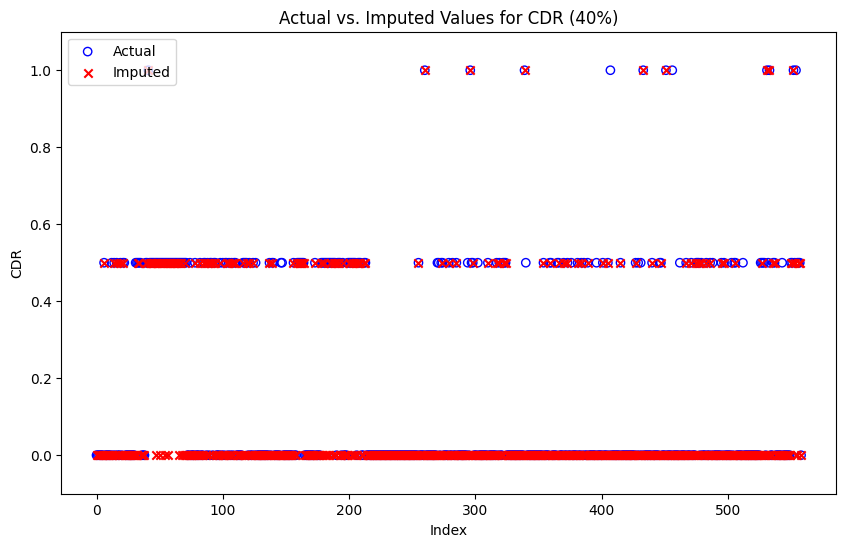

In [ ]:
import matplotlib.pyplot as plt

# Extract actual and imputed values
actual_values = df_actual['CDR']
imputed_values = df_imputed_40cdr['CDR']

# Create an array of indices from 0 to the length of the DataFrame
indices = range(len(actual_values))

# Plot the actual values and imputed values as scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(indices, actual_values, label='Actual', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(indices, imputed_values, label='Imputed', marker='x', color='red')
plt.xlabel('Index')
plt.ylabel('CDR')
plt.title('Actual vs. Imputed Values for CDR (40%)')
plt.ylim(-0.1, 1.1)  # Set y-axis limits to match the range of the actual values
plt.legend()
plt.show()


In [ ]:
# Calculating RMSE to evaluate the performance of imputation on missing values by the autoencoder.
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract actual and imputed values
actual_values = df_actual['CDR'] # contains the actual values of 'CDR'
imputed_values = df_imputed_40cdr['CDR'] # contains the imputed values of 'CDR'

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, imputed_values))
print("Root Mean Squared Error (RMSE):", rmse)



Root Mean Squared Error (RMSE): 0.18068642719686048


In [ ]:
# Calculation of accuracy of the performed imputation.
# Compute the number of correctly imputed values.
correct_imputations = (df_actual['CDR'] == df_imputed_40cdr['CDR']).sum()

# Compute the total number of imputed values
total_imputations = len(df_imputed_40cdr['CDR'])

# Compute the accuracy of the imputation
accuracy = correct_imputations / total_imputations

print("Imputation Accuracy:", accuracy)

Imputation Accuracy: 0.8855098389982111


In [ ]:
# Get the weights of the first dense layer (connecting input to hidden layer)
weights = autoencoder.layers[1].get_weights()[0]

# Calculate the importance of each feature by taking the absolute sum of weights across all hidden units
feature_importance = np.sum(np.abs(weights), axis=1)

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': df_imputed_40cdr.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top most important features
print(feature_importance_df.head())


            Feature  Importance
218             CDR    9.531578
175             AGE    9.252106
219            APOE    9.166456
31   ctx.lh.unknown    9.084954
179         PHC_EXF    9.011487


In [ ]:
### Classification using Random Forest Classifier
### Balancing by SMOTE
### Evaluation using K Fold Cross Validation

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt



# Split the dataset into features (X) and target variable (y)
X = df_imputed_40cdr.drop(columns=['AD_LABEL'])  # Features
y = df_imputed_40cdr['AD_LABEL']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE for oversampling the minority class
smote = SMOTE(random_state=40)

# Apply SMOTE only to the training data to prevent data leakage
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=50)

# Perform k-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train_resampled, y_train_resampled, cv=10)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Std CV Score:", np.std(cv_scores))

# Train the classifier on the resampled training set
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)


# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)


# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Scores: [0.89772727 0.94318182 0.89772727 0.90909091 0.96590909 0.95454545
 0.97701149 0.90804598 0.91954023 0.95402299]
Mean CV Score: 0.9326802507836991
Std CV Score: 0.028093920081506
Accuracy: 0.7589285714285714
Precision: 0.7700161569329926
Recall: 0.7589285714285714
F1-score: 0.7626766402935086

Confusion Matrix:
[[58 12  1]
 [ 8 15  4]
 [ 0  2 12]]

Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.82      0.85        71
           2       0.52      0.56      0.54        27
           3       0.71      0.86      0.77        14

    accuracy                           0.76       112
   macro avg       0.70      0.74      0.72       112
weighted avg       0.77      0.76      0.76       112



In [ ]:
# The accuracy obtained is 76%. This suggests that about 76% of the test instances were correctly classified by the model.
# For class 3, representing AD:

# Precision (0.71): Among the instances predicted as AD, 71% were correctly classified as AD, while the remaining 29% were incorrectly classified as non-AD.
# Recall (0.86): Out of all actual instances of AD, the model correctly identified 86% of them as AD, while the remaining 14% were incorrectly classified as non-AD.
# F1-score (0.77): The harmonic mean of precision and recall, providing a balanced measure of the classifier's performance, is 77%.

In [ ]:
### 50% Missingness creation in the 'CDR' column

In [ ]:
# Creating a copy of the original dataframe
df_CDR_m50 = df_actual.copy()
df_CDR_m50.head()


,lh.Cerebellum.White.Matter,lh.Cerebellum.Cortex,lh.Thalamus.Proper,lh.Caudate,lh.Putamen,lh.Pallidum,X3rd.Ventricle,X4th.Ventricle,Brain.Stem,lh.Hippocampus,...,adas_Q7SCORE,adas_Q8SCORE,adas_Q9SCORE,adas_Q10SCORE,adas_Q11SCORE,adas_Q12SCORE,adas_Q13SCORE,MOTHDEM,CDR,APOE
0,0.745525,0.794748,0.491765,0.687288,0.354272,0.053029,0.393061,1.000000,0.477280,0.619156,...,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
1,0.592240,0.665080,0.290817,0.503438,0.297870,0.041430,0.545423,0.478379,0.546091,0.398004,...,1.0,0.916667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
2,0.458426,0.530987,0.383385,0.658083,0.419540,0.068931,0.320838,0.414968,0.417480,0.398636,...,1.0,0.916667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
3,0.563800,0.587889,0.369088,0.651455,0.384590,0.048233,0.368835,0.615725,0.418360,0.480851,...,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
4,0.624248,0.664183,0.276727,0.661635,0.520853,0.120530,0.544304,0.180479,0.476558,0.290435,...,1.0,0.750000,1.0,1.0,1.0,1.0,0.8,0,0.0,0


In [ ]:
import numpy as np
# Set random seed for reproducibility
seed = 89
np.random.seed(seed)

# Define a function to introduce missingness in 'CDR' based on 'AD_LABEL'
def introduce_missingness(df_CDR_m50):
    # Define the probability of missingness
    p_missing = 0.5

    # Generate a boolean mask to identify rows where 'AD_LABEL' has values 2 or 3
    mask = (df_CDR_m50['AD_LABEL'] == 2) | (df_CDR_m50['AD_LABEL'] == 3)

    # Randomly select rows based on the mask and introduce missingness in 'CDR'
    missing_indices = df_CDR_m50[mask].sample(frac=p_missing).index
    df_CDR_m50.loc[missing_indices, 'CDR'] = np.nan

    return df_CDR_m50

  # Call the function to introduce missingness
df_CDR_mis50 = introduce_missingness(df_CDR_m50)



In [ ]:
import tensorflow as tf
import numpy as np

# Replace missing values in the 'CDR' column with a placeholder value (-1)
df_missing_CDR50 = df_CDR_mis50.fillna(-1)  # Replace NaN values with -1

# Define the architecture of the denoising autoencoder with dropout
input_dim = len(df_missing_CDR50.columns)  # Input dimension
hidden_dim1 = 126  # Hidden layer dimension for the first hidden layer
hidden_dim2 = 63  # Hidden layer dimension for the second hidden layer

# Define the autoencoder architecture with dropout regularization
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.GaussianNoise(0.1),  # Add Gaussian noise with standard deviation 0.1
    tf.keras.layers.Dense(hidden_dim1, activation='relu'),
    tf.keras.layers.Dropout(0.2),         # Dropout layer after the first hidden layer
    tf.keras.layers.Dense(hidden_dim2, activation='relu'),  # Second hidden layer
    tf.keras.layers.Dropout(0.2),         # Dropout layer after the second hidden layer
    tf.keras.layers.Dense(input_dim, activation='linear')   # Linear activation for continuous output
])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
# Train the autoencoder
autoencoder.fit(df_missing_CDR50, df_missing_CDR50, epochs=50, batch_size=50, validation_split=0.2)

# Using the trained autoencoder to predict and impute missing values
imputed_data = autoencoder.predict(df_missing_CDR50)

# Clip predicted values to ensure they are within the range [0, 1]
imputed_data = np.clip(imputed_data, 0, 1)

# Replace missing values in the original dataset with the predicted values
df_imputed_50cdr = df_CDR_mis50.copy()  # Create a copy of the original dataset
df_imputed_50cdr['CDR'] = np.where(df_CDR_mis50['CDR'].isnull(), imputed_data[:, df_CDR_mis50.columns.get_loc('CDR')], df_CDR_mis50['CDR'])


Epoch 1/50
9/9 [==============================] - 1s 45ms/step - loss: 0.1411 - val_loss: 0.1141
Epoch 2/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1042 - val_loss: 0.0764
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0767 - val_loss: 0.0520
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0556 - val_loss: 0.0370
Epoch 5/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0434 - val_loss: 0.0286
Epoch 6/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0365 - val_loss: 0.0256
Epoch 7/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0322 - val_loss: 0.0241
Epoch 8/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0302 - val_loss: 0.0232
Epoch 9/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0288 - val_loss: 0.0221
Epoch 10/50
9/9 [==============================] - 0s 17ms/step - loss: 0.0270 - val_loss: 0.0214
Epoch 11/50
9/9 [===============

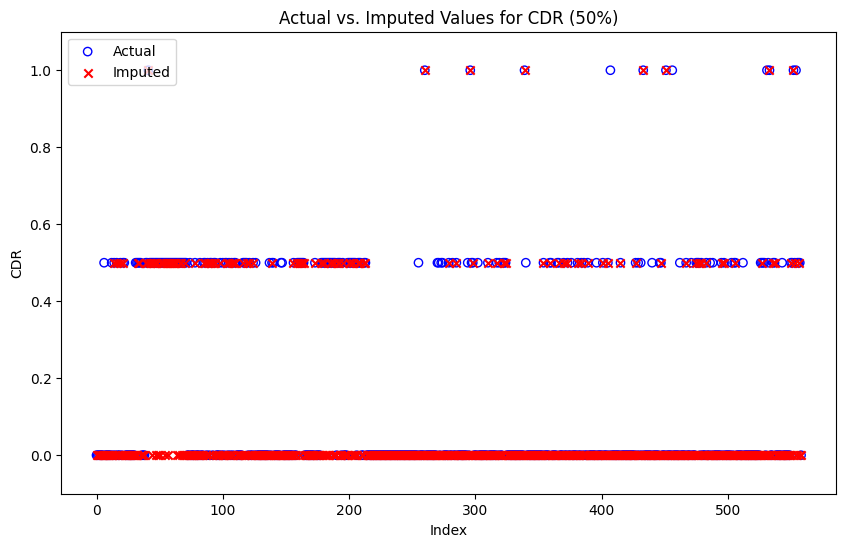

In [ ]:
# Visualising the performed imputation
import matplotlib.pyplot as plt

# Extract actual and imputed values
actual_values = df_actual['CDR']
imputed_values = df_imputed_50cdr['CDR']

# Create an array of indices from 0 to the length of the DataFrame
indices = range(len(actual_values))

# Plot the actual values and imputed values as scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(indices, actual_values, label='Actual', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(indices, imputed_values, label='Imputed', marker='x', color='red')
plt.xlabel('Index')
plt.ylabel('CDR')
plt.title('Actual vs. Imputed Values for CDR (50%)')
plt.ylim(-0.1, 1.1)  # Set y-axis limits to match the range of the actual values
plt.legend()
plt.show()


In [ ]:
# Calculating RMSE to evaluate the performance of imputation on missing values by the autoencoder.
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract actual and imputed values
actual_values = df_actual['CDR'] # contains the actual values of 'CDR'
imputed_values = df_imputed_50cdr['CDR'] # contains the imputed values of 'CDR

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, imputed_values))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.20503501162690327


In [ ]:
# Calculation of accuracy of the performed imputation.
# Compute the number of correctly imputed values.
correct_imputations = (df_actual['CDR'] == df_imputed_50cdr['CDR']).sum()

# Compute the total number of imputed values
total_imputations = len(df_imputed_50cdr['CDR'])

# Compute the accuracy of the imputation
accuracy = correct_imputations / total_imputations

print("Imputation Accuracy:", accuracy)

Imputation Accuracy: 0.853309481216458


In [ ]:
# Get the weights of the first dense layer (connecting input to hidden layer)
weights = autoencoder.layers[1].get_weights()[0]

# Calculate the importance of each feature by taking the absolute sum of weights across all hidden units
feature_importance = np.sum(np.abs(weights), axis=1)

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': df_imputed_50cdr.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top most important features
print(feature_importance_df.head())


                      Feature  Importance
219                      APOE   10.233582
176                  PTGENDER    9.911053
98       ctx.rh.supramarginal    9.021810
171  wm.rh.transversetemporal    8.966810
16       rh.Cerebellum.Cortex    8.957320


In [ ]:
### Classification using Random Forest Classifier
### Balancing by SMOTE
### Evaluation using K Fold Cross Validation

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt



# Split the dataset into features (X) and target variable (y)
X = df_imputed_50cdr.drop(columns=['AD_LABEL'])  # Features
y = df_imputed_50cdr['AD_LABEL']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE for oversampling the minority class
smote = SMOTE(random_state=40)

# Apply SMOTE only to the training data to prevent data leakage
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=50)

# Perform k-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train_resampled, y_train_resampled, cv=10)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Std CV Score:", np.std(cv_scores))

# Train the classifier on the resampled training set
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)


# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)


# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Scores: [0.89772727 0.95454545 0.85227273 0.875      0.96590909 0.95454545
 0.96551724 0.91954023 0.94252874 0.94252874]
Mean CV Score: 0.9270114942528735
Std CV Score: 0.03768021673500944
Accuracy: 0.7410714285714286
Precision: 0.7469800420168067
Recall: 0.7410714285714286
F1-score: 0.7429362961243908

Confusion Matrix:
[[59 11  1]
 [ 9 13  5]
 [ 0  3 11]]

Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.83      0.85        71
           2       0.48      0.48      0.48        27
           3       0.65      0.79      0.71        14

    accuracy                           0.74       112
   macro avg       0.67      0.70      0.68       112
weighted avg       0.75      0.74      0.74       112



In [ ]:
# The accuracy obtained is  74%. This suggests that about 74% of the test instances were correctly classified by the model.
# For class 3, representing AD:

# Precision (0.65): Among the instances predicted as AD, 65% were correctly classified as AD, while the remaining 35% were incorrectly classified as non-AD.
# Recall (0.79): Out of all actual instances of AD, the model correctly identified 79% of them as AD, while the remaining 21% were incorrectly classified as non-AD.
# F1-score (0.71): The harmonic mean of precision and recall, providing a balanced measure of the classifier's performance, is 71%.

In [ ]:
### 60% Missingness creation in 'CDR'column

In [ ]:
# Creating a copy of the original dataframe
df_CDR_m60 = df_actual.copy()
df_CDR_m60.head()


,lh.Cerebellum.White.Matter,lh.Cerebellum.Cortex,lh.Thalamus.Proper,lh.Caudate,lh.Putamen,lh.Pallidum,X3rd.Ventricle,X4th.Ventricle,Brain.Stem,lh.Hippocampus,...,adas_Q7SCORE,adas_Q8SCORE,adas_Q9SCORE,adas_Q10SCORE,adas_Q11SCORE,adas_Q12SCORE,adas_Q13SCORE,MOTHDEM,CDR,APOE
0,0.745525,0.794748,0.491765,0.687288,0.354272,0.053029,0.393061,1.000000,0.477280,0.619156,...,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
1,0.592240,0.665080,0.290817,0.503438,0.297870,0.041430,0.545423,0.478379,0.546091,0.398004,...,1.0,0.916667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
2,0.458426,0.530987,0.383385,0.658083,0.419540,0.068931,0.320838,0.414968,0.417480,0.398636,...,1.0,0.916667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
3,0.563800,0.587889,0.369088,0.651455,0.384590,0.048233,0.368835,0.615725,0.418360,0.480851,...,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
4,0.624248,0.664183,0.276727,0.661635,0.520853,0.120530,0.544304,0.180479,0.476558,0.290435,...,1.0,0.750000,1.0,1.0,1.0,1.0,0.8,0,0.0,0


In [ ]:
# Introduction of 60% missingness in 'CDR' column

import numpy as np
# Set random seed for reproducibility
seed = 500
np.random.seed(seed)

# Define a function to introduce missingness in 'CDR' based on 'AD_LABEL'
def introduce_missingness(df_CDR_m60):
    # Define the probability of missingness
    p_missing = 0.6

    # Generate a boolean mask to identify rows where 'AD_LABEL' has values 2 or 3
    mask = (df_CDR_m60['AD_LABEL'] == 2) | (df_CDR_m60['AD_LABEL'] == 3)

    # Randomly select rows based on the mask and introduce missingness in 'CDR'
    missing_indices = df_CDR_m60[mask].sample(frac=p_missing).index
    df_CDR_m60.loc[missing_indices, 'CDR'] = np.nan

    return df_CDR_m60

  # Call the function to introduce missingness
df_CDR_mis60 = introduce_missingness(df_CDR_m60)



In [ ]:
import tensorflow as tf
import numpy as np

# Replace missing values in the 'CDR' column with a placeholder value (-1)
df_missing_CDR60 = df_CDR_mis60.fillna(-1)  # Replace NaN values with -1

# Define the architecture of the denoising autoencoder with dropout
input_dim = len(df_missing_CDR60.columns)  # Input dimension
hidden_dim1 = 126  # Hidden layer dimension for the first hidden layer
hidden_dim2 = 63   # Hidden layer dimension for the second hidden layer

# Define the autoencoder architecture with dropout regularization
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.GaussianNoise(0.1),  # Add Gaussian noise with standard deviation 0.1
    tf.keras.layers.Dense(hidden_dim1, activation='relu'),
    tf.keras.layers.Dropout(0.2),         # Dropout layer after the first hidden layer
    tf.keras.layers.Dense(hidden_dim2, activation='relu'),  # Second hidden layer
    tf.keras.layers.Dropout(0.2),         # Dropout layer after the second hidden layer
    tf.keras.layers.Dense(input_dim, activation='linear')   # Linear activation for continuous output
])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
# Train the autoencoder
autoencoder.fit(df_missing_CDR60, df_missing_CDR60, epochs=50, batch_size=50, validation_split=0.2)

# Using the trained autoencoder to predict and impute missing values
imputed_data = autoencoder.predict(df_missing_CDR60)

# Clip predicted values to ensure they are within the range [0, 1]
imputed_data = np.clip(imputed_data, 0, 1)

# Replace missing values in the original dataset with the predicted values
df_imputed_60cdr = df_CDR_mis60.copy()  # Create a copy of the original dataset
df_imputed_60cdr['CDR'] = np.where(df_CDR_mis60['CDR'].isnull(), imputed_data[:, df_CDR_mis60.columns.get_loc('CDR')], df_CDR_mis60['CDR'])


Epoch 1/50
9/9 [==============================] - 1s 31ms/step - loss: 0.1470 - val_loss: 0.1148
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.1068 - val_loss: 0.0747
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0751 - val_loss: 0.0469
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0534 - val_loss: 0.0345
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0423 - val_loss: 0.0292
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0260
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0329 - val_loss: 0.0247
Epoch 8/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0231
Epoch 9/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0290 - val_loss: 0.0224
Epoch 10/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 11/50
9/9 [====================

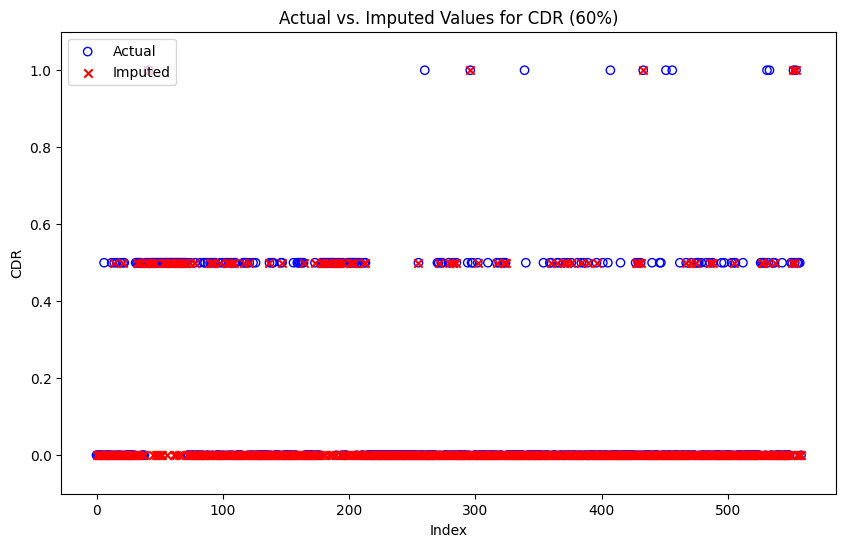

In [ ]:
import matplotlib.pyplot as plt

# Extract actual and imputed values
actual_values = df_actual['CDR']
imputed_values = df_imputed_60cdr['CDR']

# Create an array of indices from 0 to the length of the DataFrame
indices = range(len(actual_values))

# Plot the actual values and imputed values as scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(indices, actual_values, label='Actual', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(indices, imputed_values, label='Imputed', marker='x', color='red')
plt.xlabel('Index')
plt.ylabel('CDR')
plt.title('Actual vs. Imputed Values for CDR (60%)')
plt.ylim(-0.1, 1.1)  # Set y-axis limits to match the range of the actual values
plt.legend()
plt.show()


In [ ]:
# Calculating RMSE to evaluate the performance of imputation on missing values by the autoencoder.
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract actual and imputed values
actual_values = df_actual['CDR'] # contains the actual values of 'CDR'
imputed_values = df_imputed_60cdr['CDR'] # contains the imputed values of 'CDR'

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, imputed_values))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.2316619583997091


In [ ]:
# Calculation of accuracy of the performed imputation.
# Compute the number of correctly imputed values.
correct_imputations = (df_actual['CDR'] == df_imputed_60cdr['CDR']).sum()

# Compute the total number of imputed values
total_imputations = len(df_imputed_60cdr['CDR'])

# Compute the accuracy of the imputation
accuracy = correct_imputations / total_imputations

print("Imputation Accuracy:", accuracy)

Imputation Accuracy: 0.8228980322003577


In [ ]:
# Get the weights of the first dense layer (connecting input to hidden layer)
weights = autoencoder.layers[1].get_weights()[0]

# Calculate the importance of each feature by taking the absolute sum of weights across all hidden units
feature_importance = np.sum(np.abs(weights), axis=1)

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': df_imputed_60cdr.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top most important features
print(feature_importance_df.head())


                    Feature  Importance
126        wm.lh.precentral    9.351707
150           wm.rh.lingual    8.977975
220                    APOE    8.962970
111  wm.lh.inferiortemporal    8.961801
191                 FATHDEM    8.959036


In [ ]:
### Classification using Random Forest Classifier
### Balancing by SMOTE
### Evaluation using K Fold Cross Validation

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt


# Split the dataset into features (X) and target variable (y)
X = df_imputed_60cdr.drop(columns=['AD_LABEL'])  # Features
y = df_imputed_60cdr['AD_LABEL']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE for oversampling the minority class
smote = SMOTE(random_state=40)

# Apply SMOTE only to the training data to prevent data leakage
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=50)

# Perform k-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train_resampled, y_train_resampled, cv=10)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Std CV Score:", np.std(cv_scores))

# Train the classifier on the resampled training set
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)


# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)


# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Scores: [0.88636364 0.96590909 0.875      0.90909091 0.94318182 0.93181818
 0.98850575 0.93103448 0.93103448 0.93103448]
Mean CV Score: 0.9292972831765935
Std CV Score: 0.0320219394179782
Accuracy: 0.7232142857142857
Precision: 0.7181591386554622
Recall: 0.7232142857142857
F1-score: 0.7194869883437246

Confusion Matrix:
[[59 11  1]
 [11 11  5]
 [ 1  2 11]]

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83        71
           2       0.46      0.41      0.43        27
           3       0.65      0.79      0.71        14

    accuracy                           0.72       112
   macro avg       0.65      0.67      0.66       112
weighted avg       0.72      0.72      0.72       112



In [ ]:
# The accuracy obtained is 72%. This suggests that about 72% of the test instances were correctly classified by the model.
# For class 3, representing AD:

# Precision (0.65): Among the instances predicted as AD, 65% were correctly classified as AD, while the remaining 35% were incorrectly classified as non-AD.
# Recall (0.79): Out of all actual instances of AD, the model correctly identified 79% of them as AD, while the remaining 21% were incorrectly classified as non-AD.
# F1-score (0.71): The harmonic mean of precision and recall, providing a balanced measure of the classifier's performance, is 71%.

In [ ]:
### 70% missingness creation in 'CDR' column

In [ ]:
# Creating a copy of the original dataframe
df_CDR_m70 = df_actual.copy()
df_CDR_m70.head()

,lh.Cerebellum.White.Matter,lh.Cerebellum.Cortex,lh.Thalamus.Proper,lh.Caudate,lh.Putamen,lh.Pallidum,X3rd.Ventricle,X4th.Ventricle,Brain.Stem,lh.Hippocampus,...,adas_Q7SCORE,adas_Q8SCORE,adas_Q9SCORE,adas_Q10SCORE,adas_Q11SCORE,adas_Q12SCORE,adas_Q13SCORE,MOTHDEM,CDR,APOE
0,0.745525,0.794748,0.491765,0.687288,0.354272,0.053029,0.393061,1.000000,0.477280,0.619156,...,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
1,0.592240,0.665080,0.290817,0.503438,0.297870,0.041430,0.545423,0.478379,0.546091,0.398004,...,1.0,0.916667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
2,0.458426,0.530987,0.383385,0.658083,0.419540,0.068931,0.320838,0.414968,0.417480,0.398636,...,1.0,0.916667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
3,0.563800,0.587889,0.369088,0.651455,0.384590,0.048233,0.368835,0.615725,0.418360,0.480851,...,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0,0.0,0
4,0.624248,0.664183,0.276727,0.661635,0.520853,0.120530,0.544304,0.180479,0.476558,0.290435,...,1.0,0.750000,1.0,1.0,1.0,1.0,0.8,0,0.0,0


In [ ]:
import numpy as np
# Set random seed for reproducibility
seed = 100
np.random.seed(seed)

# Define a function to introduce missingness in 'CDR' based on 'AD_LABEL'
def introduce_missingness(df_CDR_m70):
    # Define the probability of missingness
    p_missing = 0.7

    # Generate a boolean mask to identify rows where 'AD_LABEL' has values 2 or 3
    mask = (df_CDR_m70['AD_LABEL'] == 2) | (df_CDR_m70['AD_LABEL'] == 3)

    # Randomly select rows based on the mask and introduce missingness in 'CDR

    missing_indices = df_CDR_m70[mask].sample(frac=p_missing).index
    df_CDR_m70.loc[missing_indices, 'CDR'] = np.nan

    return df_CDR_m70

  # Call the function to introduce missingness
df_CDR_mis70 = introduce_missingness(df_CDR_m70)



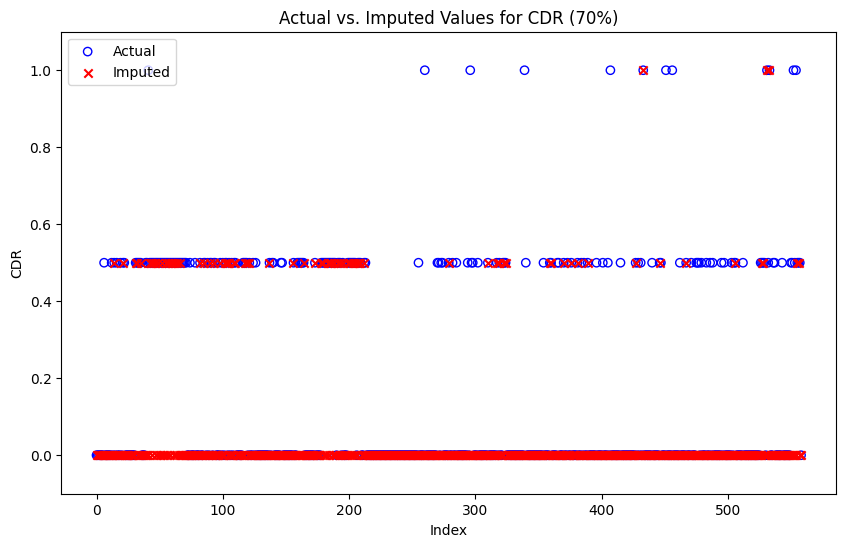

In [ ]:
# Visualization of the imputed values vs actual values
import matplotlib.pyplot as plt

# Extract actual and imputed values
actual_values = df_actual['CDR']
imputed_values = df_imputed_70cdr['CDR']

# Create an array of indices from 0 to the length of the DataFrame
indices = range(len(actual_values))

# Plot the actual values and imputed values as scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(indices, actual_values, label='Actual', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(indices, imputed_values, label='Imputed', marker='x', color='red')
plt.xlabel('Index')
plt.ylabel('CDR')
plt.title('Actual vs. Imputed Values for CDR (70%)')
plt.ylim(-0.1, 1.1)  # Set y-axis limits to match the range of the actual values
plt.legend()
plt.show()


In [ ]:
# Calculating RMSE to evaluate the performance of imputation on missing values by the autoencoder.
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract actual and imputed values
actual_values = df_actual['CDR'] # contains the actual values of 'CDR'
imputed_values = df_imputed_70cdr['CDR'] # contains the imputed values of 'CDR'

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, imputed_values))
print("Root Mean Squared Error (RMSE):", rmse)



Root Mean Squared Error (RMSE): 0.2546525922799913


In [ ]:
# Calculation of accuracy of the performed imputation.
# Compute the number of correctly imputed values.
correct_imputations = (df_actual['CDR'] == df_imputed_70cdr['CDR']).sum()

# Compute the total number of imputed values
total_imputations = len(df_imputed_70cdr['CDR'])

# Compute the accuracy of the imputation
accuracy = correct_imputations / total_imputations

print("Imputation Accuracy:", accuracy)

Imputation Accuracy: 0.7889087656529516


In [ ]:
# Get the weights of the first dense layer (connecting input to hidden layer)
weights = autoencoder.layers[1].get_weights()[0]

# Calculate the importance of each feature by taking the absolute sum of weights across all hidden units
feature_importance = np.sum(np.abs(weights), axis=1)

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': df_imputed_70cdr.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top most important features
print(feature_importance_df.head())



                         Feature  Importance
220                         APOE   10.323009
205                 adas_Q4SCORE    9.480694
22                   rh.Amygdala    9.369871
2             lh.Thalamus.Proper    9.311411
79   ctx.rh.lateralorbitofrontal    9.043641


In [ ]:
### Classification using Random Forest Classifier
### Balancing by SMOTE
### Evaluation using K Fold Cross Validation

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt



# Split the dataset into features (X) and target variable (y)
X = df_imputed_70cdr.drop(columns=['AD_LABEL'])  # Features
y = df_imputed_70cdr['AD_LABEL']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE for oversampling the minority class
smote = SMOTE(random_state=40)

# Apply SMOTE only to the training data to prevent data leakage
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=50)

# Perform k-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train_resampled, y_train_resampled, cv=10)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Std CV Score:", np.std(cv_scores))

# Train the classifier on the resampled training set
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)


# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)


# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Scores: [0.89772727 0.93181818 0.84090909 0.92045455 0.95454545 0.95454545
 0.98850575 0.91954023 0.94252874 0.95402299]
Mean CV Score: 0.9304597701149424
Std CV Score: 0.03813448271438358
Accuracy: 0.7142857142857143
Precision: 0.7063824333561175
Recall: 0.7142857142857143
F1-score: 0.7071627352239597

Confusion Matrix:
[[58 11  2]
 [12 10  5]
 [ 1  1 12]]

Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.82      0.82        71
           2       0.45      0.37      0.41        27
           3       0.63      0.86      0.73        14

    accuracy                           0.71       112
   macro avg       0.63      0.68      0.65       112
weighted avg       0.71      0.71      0.71       112



In [ ]:
# The accuracy obtained is 71%. This indicates that around 71% of the test instances were correctly classified by the model.
# Regarding class 3 (AD):

# Precision (0.63): Out of the instances predicted as AD, 63% were correctly classified as AD, while the remaining 37% were incorrectly classified as non-AD.
# Recall (0.86): Among all actual instances of AD, the model correctly identified 86% of them as AD, while the remaining 14% were incorrectly classified as non-AD.
# F1-score (0.73): The harmonic mean of precision and recall, providing a balanced measure of the classifier's performance, is 73%.
# These metrics suggest that the model has relatively good recall but lower precision for AD. It correctly identifies a high proportion of true AD cases, but it also tends to misclassify some non-AD instances as AD. There's room for improvement, particularly in precision, to reduce false positives.

In [ ]:
# The results revealed a notable trend, across all features ('MOTHDEM', 'APOE', and 'CDR')
# It has observed a gradual increase in RMSE scores as the level of missingness escalated.
# This trend suggested a decrease in imputation accuracy with higher levels of missing data.